# Linear interpolation of magnetic anomaly data

I was going to use [Verde Spline interpolator](https://www.fatiando.org/verde/latest/gallery/spline.html?highlight=regular), but it gave me a MemoryError. The same happened with most of scipy interpolators, including interp2d.

Trying to use scipy generic_filter to interpolate in moving windows was too slow to yield any results.

Since I decimated the data to a regular grid, I'll try to take advantage of that when interpolating.

In [1]:
import matplotlib.pyplot as plt
import verde as vd
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

import numpy as np

In [2]:
# Load the data as read only
data = np.load('../data/interim/MAGIGRF_DECIMATED_150x150m.npy', mmap_mode='r')

This shall be the final interpolated grid size

In [3]:
x = np.unique(data['x']) # Grid x coordinates
y = np.unique(data['y']) # Grid y coordinates

print('Grid size: {0} x {1}'.format(x.shape[0], y.shape[0]))

Grid size: 2903 x 2041


In [4]:
# Start with a sample blank image to see where the holes are
shape = (x.shape[0], y.shape[0])
img = np.full(shape, np.nan)

In [5]:
# Fill the bins as needed
img[np.digitize(data['x'], x) - 1, np.digitize(data['y'], y) - 1] = data['data']

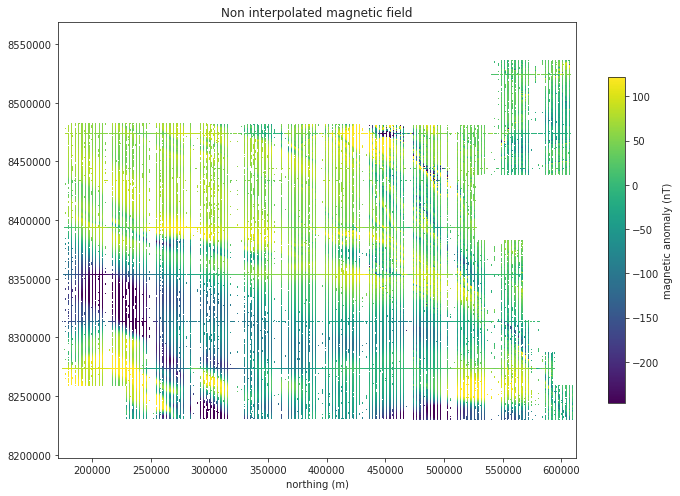

In [6]:
vmin, vmax = np.percentile(data['data'], [2,98])

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
extent=[x.min(),x.max(), y.min(), y.max()]
ax.set_title('Non interpolated magnetic field')
im = ax.imshow(img.T, interpolation='none', aspect='auto',
           vmin=vmin, vmax=vmax, cmap='viridis',
           extent=extent)
plt.colorbar(im, shrink=0.75, label='magnetic anomaly (nT)')
ax.set_aspect('equal', 'datalim')

plt.xlabel('easting (m)')
plt.xlabel('northing (m)')
plt.tight_layout();

Note: Some pixels appear missing due to the image size on the plot

## Quicklook with 1D interpolation along x axis

In [7]:
%%time
interp_x = np.array([np.interp(x, xp=x[~np.isnan(col)], fp=col[~np.isnan(col)],
                               left=np.nan, right=np.nan) for col in img.T]).T

CPU times: user 460 ms, sys: 25.6 ms, total: 486 ms
Wall time: 268 ms


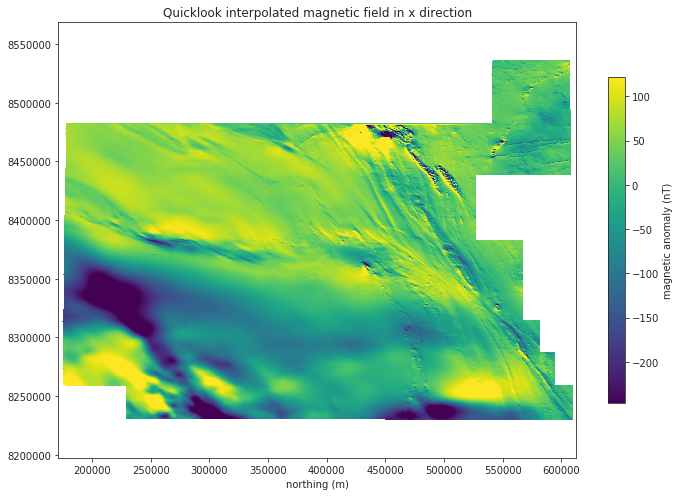

In [8]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
extent=[x.min(),x.max(), y.min(), y.max()]
ax.set_title('Quicklook interpolated magnetic field in x direction')
im = ax.imshow(interp_x.T, interpolation='none', aspect='auto',
           vmin=vmin, vmax=vmax, cmap='viridis',
           extent=extent)
plt.colorbar(im, shrink=0.75, label='magnetic anomaly (nT)')
ax.set_aspect('equal', 'datalim')
plt.xlabel('easting (m)')
plt.xlabel('northing (m)')
plt.tight_layout();

In [9]:
from scipy.interpolate import LinearNDInterpolator

In [10]:
%%time

# I'll use a linear interpolator with Delaunay triangulation
linear_interpolator = LinearNDInterpolator((data['x'], data['y']), data['data'], fill_value=np.nan)

CPU times: user 18.2 s, sys: 644 ms, total: 18.8 s
Wall time: 18.8 s


In [11]:
%%time
# Coordinates for interpolation
X, Y = np.meshgrid(x,y)

interpolated = linear_interpolator(X,Y)

CPU times: user 7.66 s, sys: 0 ns, total: 7.66 s
Wall time: 7.66 s


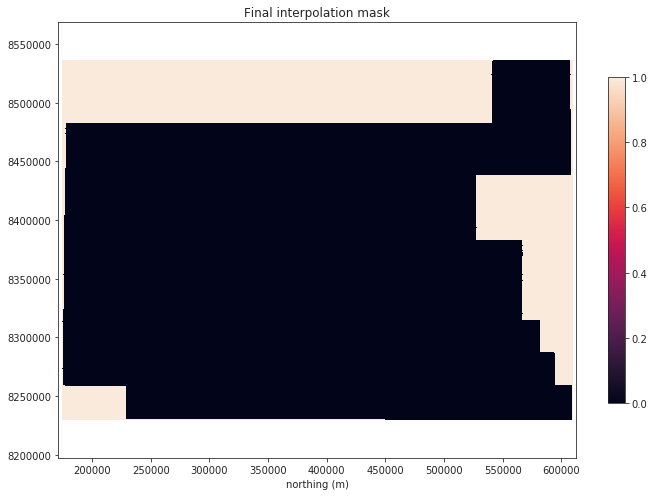

In [12]:
def create_mask(row):
    retval = np.full(row.shape, True)
    
    i =  np.where(~np.isnan(row))[0]
    n = len(i)
    
    if n == 0:
        return retval
    
    elif n == 1:
        retval[i[0]] = False
        return retval
    
    elif n >= 2:
        retval[i[0]:i[-1]] = False
        return retval
    
mask = np.array([create_mask(col) for col in img.T])

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
extent=[x.min(),x.max(), y.min(), y.max()]
ax.set_title('Final interpolation mask')
im = ax.imshow(mask.astype(np.int), interpolation='none', aspect='auto',
               extent=extent)
plt.colorbar(im, shrink=0.75)
ax.set_aspect('equal', 'datalim')
plt.xlabel('easting (m)')
plt.xlabel('northing (m)')
plt.tight_layout();

In [13]:
# Masked final linear interpolated magnetic field
final = np.ma.array(interpolated, mask=mask)

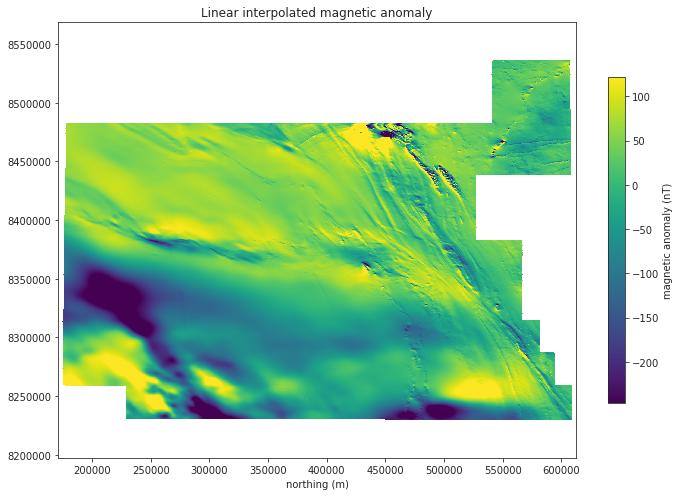

In [14]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
extent=[x.min(),x.max(), y.min(), y.max()]
ax.set_title('Linear interpolated magnetic anomaly')
im = ax.imshow(final, interpolation='none', aspect='auto',
           vmin=vmin, vmax=vmax, cmap='viridis',
           extent=extent)
plt.colorbar(im, shrink=0.75, label='magnetic anomaly (nT)')
ax.set_aspect('equal', 'datalim')
plt.xlabel('easting (m)')
plt.xlabel('northing (m)')
plt.tight_layout();